<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI286 - Computación Científica II</h1>
    <h1> Tarea 1: Deflation y Matrices Sparse </h1> 
    <h3> Cesar Contreras Zamorano </h3>
    <h3> cesar.contrerasz@sansano.usm.cl </h3>
    <h3> 2973060-1 </h3>
</center>

---

In [506]:
import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import eigs
import time
from scipy.sparse import csr_matrix
import sys
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact

## Contexto

Esta tarea tiene como objetivo aplicar los contenidos vistos en clase, respecto a métodos numéricos para obtener valores y vectores propios. Además, esta instancia servirá para recordar (o aprender) el uso de *Jupyter Notebook*, junto con las principales bibliotecas del curso: *Numpy* y *Scipy*.

## Sección 1: Algoritmo Deflation (30 puntos)

Se discutió en clases que una de las principales propiedades que tienen las matrices simétricas es que

* Sus valores propios son reales.
* Sus vectores propios son ortogonales.

Sabemos que por medio de *Power Iteration* e *Inverse Power Iteration*, podemos rescatar algunos de los valores propios y vectores propios. Mediante *Normalized Simultaneous Iteration* o *Unshifted QR*, podemos extraer todos los valores y vectores propios al mismo tiempo. Ahora veremos un método distinto para extraer los valores y vectores propios, uno por uno.

Consideremos una matriz $A \in \mathbb{R}^{n \times n}$ simétrica cuyos valores propios son $\lambda_i$ (por simplicidad, consideraremos que también son todos positivos) y sus vectores propios son $\mathbf{v}_i$, para $i \in \{1, 2, \dots, n\}$. Considere además que $\lambda_i > \lambda_j$, para todo $i < j$, es decir, los valores propios están ordenados. Considere ahora la matriz $A_1$ definida como:

$$
    A_1 = A - \lambda_1\mathbf{v}_1\,\mathbf{v}_1^T.
$$

**1. (5 puntos)** Demuestre que los vectores propios de $A$ también son los vectores propios de $A_1$. ¿Cuáles son los valores propios de $A_1$?

Consideremos el hecho de que los valores propios estan ordenados y que estamos operando con matrices simetricas, tomemos el vector propio dominante de A y multipliquemoslo por $A_1$:

$A_1 v_{1} = (A − \lambda_{1} v_{1} v_{1}^{T})v_{1}$

$A_1 v_{1} = A v_{1} − \lambda_{1} v_{1} v_{1}^{T} v_{1}$
$A_1 v_{i} = \lambda_{1} v_{i} − \lambda_{1} v_{1} v_{1}^{T} v_{1}$

Pero sabemos que $v_{1}^{T} v_{1} = 1$, entonces
$A_1 v_{i} = \lambda_{1} v_{1} v_{1}^{T})v_{1}$

Por tanto podemos notar que el valor propio asociado a $v_1$ es cero. Por no tanto no es su valor propio dominante como ocurría con A.

Ahora consideremos un vector cualquiera v, con v distinto de $v_1$:

$A_1 v = (A − \lambda_{1} v_{1} v_{1}^{T})v$

$A_1 v = A v − \lambda_{1} v_{1} v_{1}^{T} v $

$A_1 v = \lambda v − \lambda_{1} v_{1} v_{1}^{T} v$

Pero sabemos que $v_{1}^{T} v= 0$, entonces
$A_1 v = \lambda v$

de esta manera podemos ver que el vector v es vector propio de $A_1$ con valor propio asociado $\lambda$, por tanto $A_1$ tienen los mismos valores propios y y vectores que A, con excepcion de $\lambda_1=0$ que implica que el valor dominante de $A_1$ es $\lambda_2 $ y el vector propio dominante es $v_2$

**2. (10 puntos)** El proceso anterior, denominado *Deflation*, puede repetirse iterativamente para construir un algoritmo iterativo que permita encontrar los valores y vectores propios en sucesión. El algoritmo, paso a paso, puede definirse como:

1. Se define $A_0 = A$, $\lambda_0 = 0$ y $\mathbf{v}_0 = \mathbf{0}$.
2. Para $i \in \{1, 2, \dots, n\}$
    1. Se define $A_i = A_{i-1} - \lambda_{i-1}\mathbf{v}_{i-1}\,\mathbf{v}_{i-1}^T$.
    2. Se encuentra el valor y vector propio dominante de $A_{i}$, denotados por $\lambda_{i}$ y $\mathbf{v}_{i}$, respectivamente.
3. Se retorna el conjunto $\{\lambda_1, \lambda_2, \dots, \lambda_n\}$ y $\{ \mathbf{v}_{1}, \mathbf{v}_{2}, \dots, \mathbf{v}_{n}\}$.

Implemente la función `deflation`, el cual aplicará el algoritmo *Deflation* mediante el uso de *Power Iteration*. Esta función debe recibir como parámetros:
* La matriz $A$.
* Un *initial guess* $\mathbf{x}_0$.
* Un número de iteraciones.

La función debe retornar una lista con los valores propios encontrados y una lista de los vectores propios encontrados.

In [226]:
'''
    Program 12.1 Power iteration
    Computes dominant eigenvector of square matrix
    Input: matrix A, initial (nonzero) vector x, number of steps k
    Output: dominant eigenvalue lam, eigenvector u
'''
def power_iteration(A, x, k, verbose=False):
    if verbose: print("Power Iteration Method\n%s"%('='*80))
    for j in range(k):
        u = x/norm(x)
        x = np.dot(A, u)
        lam = np.dot(u, x) #not really necessary to compute it at each iteration
        if verbose: print("k=%d, lambda=%+.3f, u=%s"%(j,lam,str(u.T)))
    u = x/norm(x)
    if verbose: print("k=%d, lambda=%+.3f, u=%s\n"%(j+1,lam,str(u.T)))
    return lam, u 

'''
Given a list of n real vaues, returns a symmetric matrix whose eigenvalues are the given values.
Input:
eig_values - (list) list of n real values that will be used as eigenvalues
Output: 
A - (n x n matrix) A symmetric matrix whose eigenvalues equals the values in eig_values list
Q - (n x n matrix) An orthonormal matrix whose columns are the eigenvectors
eig_values (list) A list with eigenvalues of A. It is the same list given as input.
'''
def generate_matrix(eig_values):
    n = len(eig_values)
    Q, _ = np.linalg.qr(np.random.rand(n, n))
    L = np.diag(eig_values)
    A = np.dot(Q, np.dot(L, Q.T))
    return A, Q, eig_values

'''
Compute all the eigenvalues and eigenvectors using Deflation procedure.
Input:
A - (n x n matrix) Matrix to compute its eigenvalues and eigenvectors
x0 - (array) Initial guess for Power Iteration
it - (integer) Number of iteration for Power Iteration.
Output:
eig_values - (list) A list with the eigenvalues found by the algorithm
eig_vectors - (list) A list with the eigenvectors found by the algorithm
'''
def deflation(A, x0, it):
    #valores iniciales
    A_i = A
    lambd_i = 0
    v_i = np.zeros(np.shape(A)[0])
    #variables para ir almacenando eigenvalues y eigenvectors
    eig_values = []
    eig_vectors = []
    for a in range(np.shape(A)[0]):
        #utilizamos power iteration para 
        eig_value_, eig_vector_ = power_iteration(A_i, x0, it, verbose=False)
        eig_values.append(eig_value_)
        eig_vectors.append(eig_vector_)
        lambd_i = eig_value_
        v_i = eig_vector_
        aux = np.outer(np.dot(lambd_i,v_i), np.transpose(v_i))
        A_i = A_i - aux
    return eig_values, eig_vectors

Genere matrices con los siguientes valores propios:
* $\{1, 2, \dots, 10\}$.
* $\{2, 2^2, 2^3, \dots, 2^{12}\}$.

Utilice las matrices generadas para probar su algoritmo. Su tarea será probada con otras matrices, pero puede utilizar estas para verificar la correctitud de su algoritmo.

In [334]:
it = 1000

#primer caso 
N = 10
x0 = np.ones(N)
#creacion de matriz con valores propios {1, 2, 4, ...., 10}
eigenvalues = [i+1 for i in range(N)]
A, Q, aux = generate_matrix(eigenvalues1)
#calculo mediante deflation
eigenvalues_defl, eigenvectors_defl = deflation(A, x0, it)
print("Original Eigenvalues: {}\nEigenvalues Calculated with deflation: {}\n".format(eigenvalues, [round(temp,2)for temp in eigenvalues_defl]))

#segundo caso
N = 12
x0 = np.ones(N)
#creacion de matriz con valores propios {2^1, 2^2, 2^3, ...., 2^12}
eigenvalues = [2**(i+1) for i in range(N)]
A, Q, aux = generate_matrix(eigenvalues)
#calculo mediante deflation
eigenvalues_defl, eigenvectors_defl = deflation(A, x0, it)
print("Original Eigenvalues: {}\nEigenvalues Calculated with deflation: {}\n".format(eigenvalues, [round(temp,2)for temp in eigenvalues_defl]))

Original Eigenvalues: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Eigenvalues Calculated with deflation: [10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]

Original Eigenvalues: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
Eigenvalues Calculated with deflation: [4096.0, 2048.0, 1024.0, 512.0, 256.0, 128.0, 64.0, 32.0, 16.0, 8.0, 4.0, 2.0]



**3. (15 puntos)** Implemente el algoritmo *Normalized Simultaneous Iteration* (NSI). Genere matrices de los siguientes tamaños, utilizando la función `generate_matrix`:

* $100 \times 100$.
* $1000 \times 1000$.
* $10000 \times 10000$.
* $15000 \times 15000$.

Estime teóricamente cuanta memoria requiere cada uno de los algoritmos. Además, ejecute ambos algoritmos sobre las matrices generadas y mida el tiempo de ejecución. Concluya respecto a los resultados.

In [346]:
#ref: http://mlwiki.org/index.php/Power_Iteration#Orthogonal_Iteration 
def normalized_simultaneous_power_iteration(A, k, it):
    #generacion de vectores aleatorios
    n, m = np.shape(A)
    Q = np.random.rand(n, k)
    #factorizacion QR para obtener el vector Q ortonormal
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
    for i in range(it):
        Z = A.dot(Q)
        Q, R = np.linalg.qr(Z)
    return np.diag(R), Q

In [362]:
it = 100
#primer caso 
N_2 = [100, 1000, 15000]
N_ = [10, 100, 200, 300, 400, 500]
y_defl = []
y_nsi = []
print("Prueba ejecutada Usando valores propios de la forma 1, 2, 3, ... n \n para generate_matrix")
#reemplazar por N_2 para probar con los casos originales
for N in N_:
    print("Tiempos de ejecucion para el caso {}x{}".format(N,N))
    x0 = np.ones(N)
    #creacion de matriz con valores propios {1, 2, 4, ...., 10}
    eigenvalues = [i+1 for i in range(N)]
    A, Q, aux = generate_matrix(eigenvalues)
    
    #calculo mediante deflation
    start = time.perf_counter()
    eigenvalues_defl, eigenvectors_defl = deflation(A, x0, it)
    time_ = time.perf_counter() - start
    y_defl.append(time_)
    print("Con deflation:{}".format(time_))
    
    #calculo mediante NSI
    start = time.perf_counter()
    eigenvalues_nsi, eigenvectors_nsi = normalized_simultaneous_power_iteration(A, N, it)
    time_ = time.perf_counter() - start
    y_nsi.append(time_)
    print("Con NSI:{}\n".format(time_))

Prueba ejecutada Usando valores propios de la forma 1, 2, 3, ... n 
 para generate_matrix
Tiempos de ejecucion para el caso 10x10
Con deflation:0.020199800026603043
Con NSI:0.011212700046598911

Tiempos de ejecucion para el caso 100x100
Con deflation:0.14981279999483377
Con NSI:0.07364299998153001

Tiempos de ejecucion para el caso 200x200
Con deflation:0.41973119997419417
Con NSI:0.27207910001743585

Tiempos de ejecucion para el caso 300x300
Con deflation:1.0773079000064172
Con NSI:0.827541500038933

Tiempos de ejecucion para el caso 400x400
Con deflation:3.012690100003965
Con NSI:1.8855878999456763

Tiempos de ejecucion para el caso 500x500
Con deflation:4.849398599995766
Con NSI:3.2943824999965727



Dado que los tiempos de computo se escapan al tiempo que tengo para entregar la tarea, se optó por probar con tamaños de matrices mas pequeñas N = [10,100,300,400,500], y en base a esto generar un grafico para analizar. Podemos ver claramente que la diferencia entre el tiempo de calculo de ambos algoritmos no crece linealmente a medida que el tamaño de la matriz crece, y por tanto para matrices demasiado grandes, resulta impractico el calculo de esta manera, sobre todo con NSI, que es el que mas demora.

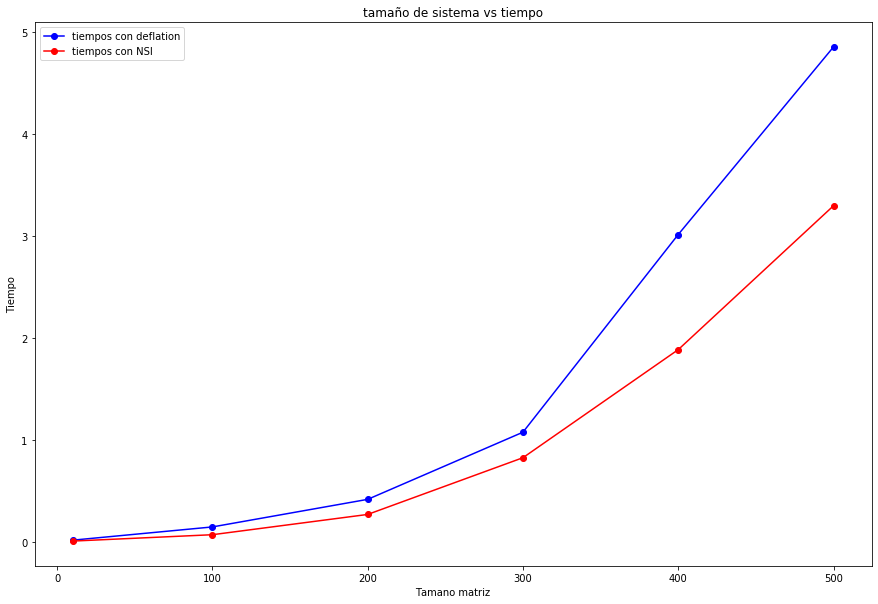

In [377]:
#construimos nuestro grafico
x = N_
plt.figure(figsize=(15,10))
plt.title("tamaño de sistema vs tiempo")
plt.plot(x,y_defl,'bo-', label='tiempos con deflation')
plt.plot(x,y_nsi,'ro-', label='tiempos con NSI')
plt.xlabel("Tamano matriz")
plt.ylabel("Tiempo")
plt.legend
plt.legend()

Estimando la memoria en base a n (tamaño de la matriz). Para el algoritmo deflation necesitamos:

$n^2$ para almacenar A  
$n^2 + 2n$ variables para calcular power_iteration (para A, x y para calcular lambda)  
Entonces necesitamos al menos $2 n^2  + 2n \implies  (2 n^2  + 2n) \cdot 8[B] $


Por otro lado para NSI necesitamos:  
$n^2$ para almacenar A 
$n^2$ para almacenar $Q_0$  
$n^2$ para almacenar Q, luego de hacer QR (no almacenamos R)  
$2 n^2$ para almacenar Q y diag(R) que se retornan  

Entonces necesitamos al menos 5 matrices de $n x n \implies  5n^2 \cdot 8[B] $

Con esto podemos tener una idea de que estos algoritmos no nos serviran para matrices densas demasiado grandes (se descartaron variables pequeñas en comparacion con las matrices)

## Sección 2: Uso de matrices *Sparse* (60 puntos)

Cuando una matriz es de tipo *Sparse*[1], es posible trabajar sobre matrices de mayor tamaño, debido a que se evita el almacenamiento de valores *innecesarios* (en este caso, los ceros).

**1. (5 puntos)** Implemente la función `read_sparse_matrix` que reciba la ruta a un archivo de texto plano que contiene una matriz *sparse*, y construya la matriz respectiva utilizando una estructura de datos especializada para matrices *sparse*[2]. El formato del archivo será:
* La primera línea del archivo contendrá un solo número `N`, donde `N` indica el tamaño de la matriz (matriz de tamaño `N`$\times$`N`).
* Cada una de las siguientes líneas contiene 3 números separados por espacios, que indicarán las entradas no nulas de la matriz. Si la línea contiene los números `i j a`, esto indica que en la fila `i` y columna `j`, la matriz tiene un coeficiente con valor `a`.

In [319]:
'''
Read a file in the specified format to build a Sparse Matrix.
Input:
path - (string) A path to a file.
Output:
A - (N x N matrix) The matrix in a sparse format.
'''
def read_sparse_matrix(path):
    verbose = False
    f = open(path, "r")
    #obtenemos el tamaño de la matriz
    N = int(f.readline())
    row = []
    col = []
    data = []
    for line in f:
        #leemos los 3 elementos de cada linea
        row_, col_, data_ = line.split()
        if verbose: print("A_({},{}) = {}".format(row_, col_, data_))
        #generamos un vector de indices fila
        row.append(int(row_))
        #generamos un vector de indices columna
        col.append(int(col_))
        #generamos un vector de datos != de cero para los indices definidos en row y col
        data.append(float(data_))
    #instanciamos nuestra matriz sparse en base a los indices y datos definidos en row, col y data
    return csr_matrix((data, (row, col)), shape=(N,N))

matrix_10000 = read_sparse_matrix("matrix_10000.txt")
matrix_20000 = read_sparse_matrix("matrix_20000.txt")
matrix_50000 = read_sparse_matrix("matrix_50000.txt")

Cargue las matrices adjuntas en los archivos `matrix_10000.txt`, `matrix_20000.txt` y `matrix_50000.txt`, de dimensiones $10000 \times 10000$, $20000 \times 20000$ y $50000\times50000$ respectivamente, utlizando la función `read_sparse_matrix`. Considerando *double precision* para los números de punto flotante, indique cuánta memoria utilizarían estas matrices si fuesen cargadas utilizando arreglos bidimensionales o estructuras no-especializadas para matrices *sparse*. ¿Existe alguna diferencia al utilizar las estructuras de datos *sparse*?

In [108]:
print("In-memory size sparse Matrices")
print("Matrix_10000: {} Bytes or {:.2f} MB".format(matrix_10000.data.nbytes, matrix_10000.data.nbytes/(1024**2)))
print("Matrix_20000: {} Bytes or {:.2f} MB".format(matrix_20000.data.nbytes, matrix_20000.data.nbytes/(1024**2)))
print("Matrix_50000: {} Bytes or {:.2f} MB".format(matrix_50000.data.nbytes, matrix_50000.data.nbytes/(1024**2)))
print("Teorical In-memory size for non-sparse Matrices (assuming 8 bytes for double precision float)")
print("Matrix_10000: {} Bytes or {:.2f} MB".format((matrix_10000.get_shape()[0]*matrix_10000.get_shape()[1])*8, ((matrix_10000.get_shape()[0]*matrix_10000.get_shape()[1])*8)/(1024**2)))
print("Matrix_20000: {} Bytes or {:.2f} MB".format((matrix_20000.get_shape()[0]*matrix_20000.get_shape()[1])*8, ((matrix_20000.get_shape()[0]*matrix_20000.get_shape()[1])*8)/(1024**2)))
print("Matrix_50000: {} Bytes or {:.2f} MB".format((matrix_50000.get_shape()[0]*matrix_50000.get_shape()[1])*8, ((matrix_50000.get_shape()[0]*matrix_50000.get_shape()[1])*8)/(1024**2)))

In-memory size sparse Matrices
Matrix_10000: 3910400 Bytes or 3.73 MB
Matrix_20000: 3038560 Bytes or 2.90 MB
Matrix_50000: 3599680 Bytes or 3.43 MB
Teorical In-memory size for non-sparse Matrices(assuming 8 bytes for double precision float)
Matrix_10000: 800000000 Bytes or 762.94 MB
Matrix_20000: 3200000000 Bytes or 3051.76 MB
Matrix_50000: 20000000000 Bytes or 19073.49 MB


**R:** Creo que lo optimo en este problema es utilizar codigo para obtener el espacio en memoria de la matriz almacenada como sparse, y compararlo con cuanta memoria debiera ocupar la matriz densa teoricamente, ya que si cargar la matriz densa en memoria y usar codigo para obtener su tamaño, nos dejaría sin memoria. De esta manera tenemos que:

- Para el caso de la matriz de 10000x10000: la matriz con estructura sparse ocupa aproximadamente un 0,4% de lo que ocuparía sin una estructura de datos sparse (almacenada tradicionalmente, como una matriz densa).
- Para el caso de la matriz de 20000x20000: la matriz con estructura sparse ocupa aproximadamente un $9,5 \cdot 10^{-4}$% de lo que ocuparía sin una estructura de datos sparse (almacenada tradicionalmente, como una matriz densa).
- Para el caso de la matriz de 50000x50000: la matriz con estructura sparse ocupa aproximadamente un $1,8 \cdot 10^{-4}$% de lo que ocuparía sin una estructura de datos sparse (almacenada tradicionalmente, como una matriz densa).

Por lo que es facil notar que la diferencia es de varios ordenes de magnitud, incluso para matrices relativamente pequeñas como las entregadas. Esto se debe a que las estructuras de datos sparse, solo guardan los datos no nulo.

**2. (25 puntos)** Suponga ahora que la matriz simétrica $A$ en el algoritmo de *Deflation* es *Sparse*. Notar que luego de calcular el valor y vector propio dominante de $A$, el resultado obtenido para calcular $A_1$:

$$
    A_1 = A - \lambda_1\mathbf{v}_1\,\mathbf{v}_1^T,
$$

**no** necesariamente es una matriz *sparse*. Esto se debe a que la matriz $\mathbf{v}_1\mathbf{v}_1^T$ no necesariamente es *sparse* y al restarse con $A$, esta propiedad puede perderse.

A pesar de lo anterior, una propiedad importante de *Power Iteration* es que no opera direcamente sobre la matriz, si no que solo es requerida a través del producto **matriz-vector**. Notar que si se desea calcular $A_1\mathbf{u}$, donde $\mathbf{u}$ es un vector arbitrario, puede calcularse como

$$
    A_1\mathbf{u} 
    = \left(A - \lambda_1\mathbf{v}_1\,\mathbf{v}_1^T\right)\mathbf{u}
    = A\mathbf{u} - \lambda_1 \mathbf{v}_1 \left(\mathbf{v}_1^T\mathbf{u}\right).
$$

De esta manera, no es necesario construir explícitamente la matriz $\mathbf{v}_1\mathbf{v}_1^T$. De manera general, la matriz $A_i\mathbf{u}$ puede calcularse como

$$
    A_i\mathbf{u} = A\mathbf{u} - \sum_{k = 1}^{i}\lambda_k \left( \mathbf{v}_k^T\mathbf{u} \right) \mathbf{v}_k.
$$

Implemente la función `A_times_vector` que reciba como parámetros: 

* Una matriz de tipo *sparse*.
* Un entero $k$.
* Una lista con $k$ valores propios.
* Una lista con $k$ vectores propios.
* Un vector $\mathbf{u}$, arbitrario.

La función debe retornar el resultado numérico del producto matriz-vector $A_{k}\mathbf{u}$.

In [486]:
'''
Implementation of a Deflation matriz-vector product to avoid building non-sparse matrix
Input:
A - (N x N matrix) A matrix in a sparse format.
k - (integer) An integer.
k_eig_values - (list) A list with k eigenvalues of A.
k_eig_vectors - (list) A list with k eigenvectors of A.
u - (array) An arbitrary vector
Output:
b - (array) The result of a Deflation matrix times u, using the given eigenvalues and eigenvectors.
'''
def A_times_vector(A_k, k, k_eig_values, k_eig_vectors, u):
    sum_ = 0
    for i in range(k):
        lambd_k = k_eig_values[i]
        v_k = k_eig_vectors[i]
        temp = np.dot(v_k.transpose(),u)
        temp = temp * v_k
        sum_ = sum_ + (lambd_k * temp) 
    b = (A_k * u) - sum_
    return b

**3. (30 puntos)** Implemente la función `sparse_deflation`, modificando su implementación inicial de *Deflation*, que permita operar sobre matrices de gran dimenensión y que sean *sparse*. Para esto, utilice la implementación realizada de la función `A_times_vector` en combinación con el algoritmo de *Power Iteration*. La función `sparse_deflation` recibe como parámetros:
* La matriz $A$ de tipo *sparse*.
* El *initial guess* $\mathbf{x}_0$.
* El número de iteraciones a realizar en *Power Iteration*
* Un número $T$ que indique el número de valores y vectores propios que se desean obtener de la matriz $A$.

In [505]:
'''
modified version of power iteration, to take into consideration that we 
dont have A, but A*u
'''
def power_iteration_sparse(myfun, A, x, it, k, k_eig_values, k_eig_vectors, verbose=False):
    if verbose: print("Power Iteration Method\n%s"%('='*80))
    for j in range(it):
        u = x/norm(x)
        x = myfun(A, k, k_eig_values,k_eig_vectors, u)
        lam = np.dot(u,x) #not really necessary to compute it at each iteration
        if verbose: print("k=%d, lambda=%+.3f, u=%s"%(j,lam,str(u.T)))
    u = x/norm(x)
    if verbose: print("k=%d, lambda=%+.3f, u=%s\n"%(j+1,lam,str(u.T)))
    return lam, u

def power_iteration1(A, x, k, verbose=False):
    if verbose: print("Power Iteration Method\n%s"%('='*80))
    for j in range(k):
        u = x/norm(x)
        x = A * u
        lam = np.dot(u, x)
        if verbose: print("k=%d, lambda=%+.3f, u=%s"%(j,lam,str(u.T)))
    u = x/norm(x)
    if verbose: print("k=%d, lambda=%+.3f, u=%s\n"%(j+1,lam,str(u.T)))
    return lam, u 

'''
Compute T eigenvalues and eigenvectors from the sparse matrix A, using Deflation.
Input:
A - (n x n matrix) Sparse matrix
x0 - (array) Initial guess for Power Iteration
it - (integer) Number of iterations for Power Iteration
T - (integer) Number of eigenvalues and eigenvectors to compute from A
Output:
eig_values - (list) List of T eigenvalues found by the algorithm
eig_vectors - (list) List of T eigenvectors found by the algorithm
'''
def sparse_deflation(A, x0, it, T):
    #variables para ir almacenando eigenvalues y eigenvectors
    eig_values = []
    eig_vectors = []
    #calculamos el primer valor propio dominante
    eig_value_, eig_vector_ = power_iteration1(A, x0, it, verbose=False)
    eig_values.append(eig_value_)
    eig_vectors.append(eig_vector_)
    #obtendremos hasta el T valor propio
    for k in range(T):
        if k > 0:
            #utilizamos power iteration para
            eig_value_, eig_vector_ = power_iteration_sparse(A_times_vector, A, x0, it, k, eig_values, eig_vectors, verbose=False)
            eig_values.append(eig_value_)
            eig_vectors.append(eig_vector_)
        #no hay necesidad de estos calculos, ya que son realizados en la funcion A_times_vector
        #lambd_i = eig_value_
        #v_i = eig_vector_
        #aux = np.outer(np.dot(lambd_i,v_i), np.transpose(v_i))
        #A_i = A_i - aux
    return eig_values, eig_vectors

#validamos que el algoritmo hace lo que debe haber obteniendo los primeros 10 valores propios
#de la matriz de 10000x10000
matrix_10000 = read_sparse_matrix("matrix_10000.txt")
it = 200
#primer caso
T = 10
x0 = np.ones(10000)
eigenvalues_sp_scipy, eigenvectors_sp_defl = eigs(matrix_10000, k=10)
print("eigenvalues_sp_numpy:{}".format(eigenvalues_sp_scipy))
eigenvalues_sp_defl, eigenvectors_sp_defl = sparse_deflation(matrix_10000, x0, it, T)
print("eigenvalues_sp_defl:{}".format(eigenvalues_sp_defl))

eigenvalues_sp_numpy:[104.6453971 +0.j  96.05815909+0.j  92.15974515+0.j  90.59870823+0.j
  88.62043639+0.j  87.90992236+0.j  87.63050846+0.j  87.08707346+0.j
  86.41053826+0.j  86.09559278+0.j]
eigenvalues_sp_defl:[104.64539710068898, 96.05815905868171, 92.1533519738743, 90.60495981215624, 88.60389520421336, 87.89531261669954, 87.01749713560802, 87.29789341552383, 86.46724937177623, 86.06222951805184]


Aplique la función `sparse_deflation` sobre las matrices cargadas desde los archivos adjuntos, para distintos valores de $T$ y de iteraciones para *Power Iteration*. Mida los tiempos de ejecución y concluya al respecto. ¿Podría haber aplicado el algoritmo NSI para estas matrices? Justifique y concluya al respecto.

In [503]:
def testing(T, it):
    files = [10000, 20000, 50000]
    y_defl_sparse = []
    for size in files:
        matrix = read_sparse_matrix("matrix_{}.txt".format(size))
        #primer caso
        x0 = np.ones(size)
        #calculo mediante deflation
        start = time.perf_counter()
        eigenvalues_sp_defl, eigenvectors_sp_defl = sparse_deflation(matrix, x0, it, T)
        time_ = time.perf_counter() - start
        y_defl_sparse.append(time_)
        print("Con deflation_sparse, T={},it={} y tamano {}x{} : {}".format(T, it, size, size, time_))
    #construimos nuestro grafico
    plt.figure(figsize=(15,10))
    plt.title("tamaño de sistema vs tiempo")
    plt.plot(files,y_defl_sparse,'bo-', label='tiempos')
    plt.xlabel("Tamano matriz")
    plt.ylabel("Tiempo")
    plt.legend()

interact(testing,T=[10,20,30,40,50],it=[50,100,150,200,1000])

interactive(children=(Dropdown(description='T', options=(10, 20, 30, 40, 50), value=10), Dropdown(description=…

<function __main__.testing(T, it)>

**Conclusiones:** El algoritmo NSI hace uso de la factorizacion A = QR, y nada asegura que la propiedad sparse de la matriz A, pueda mantenerse en Q ni en R. Como el algoritmo hace uso de Q explicitamente, no podriamos haberlo utilizado ya que habría significado guardar dos matrices potencialmente densas Q y R, por tanto nos habriamos quedado sin memoria rapidamente. Además que sabemos que QR es un algoritmo bastante costoso, por lo cual los tiempos de computo tambien habrían sido demasiado elevados. 

Por otra parte podemos ver que el algoritmo deflation para matrices sparse, realmente ofreces tiempos bastante razonables para matrices incluso de 50000x50000, lo cual es bastante apreciable al momento de ejecutar el widget. Tampoco vemos en el sistema una lentitud ni falta de memoria en lo absoluto.

---

# Referencias


[1] Sparse matrix, https://en.wikipedia.org/wiki/Sparse_matrix 
[fecha: 13-10 - 2019- 17:00]

[2] Sparse module, Scipy. https://docs.scipy.org/doc/scipy/reference/sparse.html [fecha: 12-10-2019 - 13:02]

[3] Size of a sparse Matrix, https://stackoverflow.com/questions/11173019/determining-the-byte-size-of-a-scipy-sparse-matrix [fecha: 15-10-2019 - 17:35]

[4] Normalized simultaneous Iteration. http://mlwiki.org/index.php/Power_Iteration#Orthogonal_Iteration [fecha: 15-10-2019 - 17:35]
https://www.inf.utfsm.cl/~parce/cc2/clase6-PA.html [fecha: 15-10-2019 - 17:35]

[5] https://github.com/tclaudioe/Scientific-Computing/blob/master/SC2/U1_EigenWorld.ipynb [fecha: 15-10-2019 - 17:35]